In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score
from functools import partial
import pandas as pd
import numpy as np
import scipy
import random
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import scipy.spatial.distance as dist
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [17]:
# Define the search space for each classifier
rf_space = {
    'n_estimators': hp.randint('n_estimators', 1, 50),
    'max_depth': hp.randint('max_depth',1,10),
    'min_samples_split':hp.uniform('min_samples_split', 0, 1),
    'min_samples_leaf':hp.randint('min_samples_leaf',1,10),
    'criterion':hp.choice('criterion',['gini','entropy']),
    'max_features':hp.choice('max_features',['sqrt','log2'])
}

ada_space = {
    'n_estimators': hp.randint('n_estimators', 1, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
    'algorithm': hp.choice('algorithm', ['SAMME', 'SAMME.R'])
}

nb_space = {
    'var_smoothing': hp.choice('var_smoothing', [1e-09])
}

cart_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': hp.randint('max_depth',1,10),
    'min_samples_split': hp.randint('min_samples_split', 2, 10)
}

knn_space = {
    'n_neighbors': hp.randint('n_neighbors', 5, 20),
    'algorithm': hp.choice('algorithm', ['ball_tree', 'kd_tree', 'brute'])
}

ridge_space = {
    'alpha': hp.uniform('alpha', 0.1, 1.0),
    'solver': hp.choice('solver', ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    'max_iter': hp.randint('max_iter', 1000,15000)
}

svm_space = {
    'C': hp.lognormal('C', 0.1, 1.0),
    # 'kernel': hp.choice('kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
    'kernel': hp.choice('kernel', ['linear']),
    'degree': hp.randint('degree', 1,5),
    #'gamma': hp.choice('gamma', ['scale', 'auto'])
}

mlp_space = {
    'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (50, 50)]),
    'alpha': hp.uniform('alpha', 0.0001, 0.01),
    'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    'max_iter': hp.randint('max_iter', 10, 100)
}

# Create a dictionary mapping classifiers to their search spaces
classifiers = {
    'RandomForest': (RandomForestClassifier, rf_space),
    'AdaBoost': (AdaBoostClassifier, ada_space),
    'NaiveBayes': (GaussianNB, nb_space),
    'DecisionTree': (DecisionTreeClassifier, cart_space),
    'KNN': (KNeighborsClassifier, knn_space),
    'Ridge': (RidgeClassifier, ridge_space),
    'SVM': (SVC, svm_space),
    'MLP': (MLPClassifier, mlp_space),
}

algorithm = tpe.suggest

# Data Loading()

In [18]:
# Load dataset files for each ML project by specifying correct path
def data_loading_transformers():
    transformers_2_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/transformers_4.13.0.csv')
    
    transformers_train_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13])
    transformers_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)


    transformers_test_data = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/transformers_4.23.0.csv')
  # test_data1 = pd.read_csv('transformers_4.23.0.csv')
  # ml_files = pd.read_csv('transformers_ml_files.csv')
    transformers_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)

    X_source = transformers_train_data.drop(columns='Buggy')
    Y_source = transformers_train_data['Buggy']
    X_target = transformers_test_data.drop(columns='Buggy')
    Y_target = transformers_test_data['Buggy']
    
    return X_source, Y_source, X_target, Y_target

  # print(X_source.shape)
  # print(Y_source.shape)
  # print(X_target.shape)
  # print(Y_target.shape)

# Load your dataset (replace X and y with your features and labels)
def data_loading_yolov5():
  yolov5_4_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/yolov5_4.0.csv')
  yolov5_6_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/yolov5_6.0.csv')
  

  yolov5_train_data = pd.concat([yolov5_4_0, yolov5_6_0])
  yolov5_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)


  yolov5_test_data = yolov5_7_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/yolov5_7.0.csv')
  # test_data1 = pd.read_csv('yolov5_7.0.csv')
  # ml_files = pd.read_csv('yolov5_ml_files.csv')
  yolov5_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)

  X_source = yolov5_train_data.drop(columns='Buggy')
  Y_source = yolov5_train_data['Buggy']
  X_target = yolov5_test_data.drop(columns='Buggy')
  Y_target = yolov5_test_data['Buggy']

  return X_source, Y_source, X_target, Y_target

  # print(X_source.shape)
  # print(Y_source.shape)
  # print(X_target.shape)
  # print(Y_target.shape)

# Load your dataset (replace X and y with your features and labels)
def data_loading_jax():
  jax_1_73 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.1.73.csv')
  jax_2_21 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.2.21.csv') 
  jax_2_28 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.2.28.csv')
  
  jax_train_data = pd.concat([jax_1_73, jax_2_21, jax_2_28])
  jax_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)


  jax_test_data = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.3.15.csv')
  # test_data1 = pd.read_csv('jax_0.3.15.csv')
  # ml_files = pd.read_csv('jax_ml_files.csv')
  jax_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
  #jax_test_data.shape

  X_source = jax_train_data.drop(columns='Buggy')
  Y_source = jax_train_data['Buggy']
  X_target = jax_test_data.drop(columns='Buggy')
  Y_target = jax_test_data['Buggy']

  return X_source, Y_source, X_target, Y_target

  print(X_source.shape)
  print(Y_source.shape)
  print(X_target.shape)
  print(Y_target.shape)

# Load your dataset (replace X and y with your features and labels)
def data_loading_lightning():
  lightning_0_5 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/lightning_0.5.1.csv')
  lightning_1_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/lightning_1.0.0.csv')
  lightning_1_5 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/lightning_1.5.0.csv') 
  

  lightning_train_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5])
  lightning_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)


  lightning_test_data = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/lightning_1.8.0.csv')
  # test_data1 = pd.read_csv('lightning_1.8.0.csv')
  # ml_files = pd.read_csv('lightning_ml_files.csv')
  lightning_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)

  X_source = lightning_train_data.drop(columns='Buggy')
  Y_source = lightning_train_data['Buggy']
  X_target = lightning_test_data.drop(columns='Buggy')
  Y_target = lightning_test_data['Buggy']

  return X_source, Y_source, X_target, Y_target

  # print(X_source.shape)
  # print(Y_source.shape)
  # print(X_target.shape)
  # print(Y_target.shape)

# Load your dataset (replace X and y with your features and labels)
def data_loading_ray():
  ray_0_3 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_0.3.0.csv')
  ray_0_6 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_0.6.1.csv')
  ray_0_8 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_0.8.0.csv') 
  ray_1_1 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_1.1.0.csv')
  ray_1_9 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_1.9.0.csv')
  

  ray_train_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9])
  ray_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)


  ray_test_data = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_2.0.0.csv')
  # test_data1 = pd.read_csv('ray_2.0.0.csv')
  # ml_files = pd.read_csv('ray_ml_files.csv')
  ray_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)

  X_source = ray_train_data.drop(columns='Buggy')
  Y_source = ray_train_data['Buggy']
  X_target = ray_test_data.drop(columns='Buggy')
  Y_target = ray_test_data['Buggy']

  return X_source, Y_source, X_target, Y_target

  # print(X_source.shape)
  # print(Y_source.shape)
  # print(X_target.shape)
  # print(Y_target.shape)

# Objective Function - ROC_AUC

In [19]:
# Define the objective function for hyperparameter optimization
def objective_rf(search_space):
    model = RandomForestClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)

    #print("auc: ", roc_auc)
    # Record the AUC for this trial
    #rf_trials.results.append({'auc': roc_auc, 'params': search_space, 'status': 'ok'})
    return -roc_auc

def objective_ada(search_space):
    model = AdaBoostClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)

    return -roc_auc

def objective_nb(search_space):
    model = GaussianNB(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)

    return -roc_auc

def objective_cart(search_space):
    model = DecisionTreeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)

    return -roc_auc

def objective_knn(search_space):
    model = KNeighborsClassifier(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)

    return -roc_auc

def objective_ridge(search_space):
    model = RidgeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)

    return -roc_auc

def objective_mlp(search_space):
    model = MLPClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)

    return -roc_auc

def objective_svm(search_space):
    model = SVC(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)

    return -roc_auc

# Objective Function - Precision

In [20]:
# Define the objective function for hyperparameter optimization
def objective_rf_pre(search_space):
    model = RandomForestClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)

    #print("auc: ", roc_auc)
    # Record the AUC for this trial
    #rf_trials.results.append({'auc': roc_auc, 'params': search_space, 'status': 'ok'})
    return -precision

def objective_ada_pre(search_space):
    model = AdaBoostClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)

    return -precision

def objective_nb_pre(search_space):
    model = GaussianNB(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)

    return -precision

def objective_cart_pre(search_space):
    model = DecisionTreeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)

    return -precision

def objective_knn_pre(search_space):
    model = KNeighborsClassifier(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)

    return -precision

def objective_ridge_pre(search_space):
    model = RidgeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)

    return -precision

def objective_mlp_pre(search_space):
    model = MLPClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)

    return -precision

def objective_svm_pre(search_space):
    model = SVC(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)

    return -precision

# Objective Function - Recall

In [21]:
# Define the objective function for hyperparameter optimization
def objective_rf_re(search_space):
    model = RandomForestClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return -recall

def objective_ada_re(search_space):
    model = AdaBoostClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return -recall

def objective_nb_re(search_space):
    model = GaussianNB(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return -recall

def objective_cart_re(search_space):
    model = DecisionTreeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return -recall

def objective_knn_re(search_space):
    model = KNeighborsClassifier(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return -recall

def objective_ridge_re(search_space):
    model = RidgeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return -recall

def objective_mlp_re(search_space):
    model = MLPClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return -recall

def objective_svm_re(search_space):
    model = SVC(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return -recall

# Objective Function - F1

In [22]:
# Define the objective function for hyperparameter optimization
def objective_rf_f1(search_space):
    model = RandomForestClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return -f1

def objective_ada_f1(search_space):
    model = AdaBoostClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return -f1

def objective_nb_f1(search_space):
    model = GaussianNB(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return -f1

def objective_cart_f1(search_space):
    model = DecisionTreeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return -f1

def objective_knn_f1(search_space):
    model = KNeighborsClassifier(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return -f1

def objective_ridge_f1(search_space):
    model = RidgeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return -f1

def objective_mlp_f1(search_space):
    model = MLPClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return -f1

def objective_svm_f1(search_space):
    model = SVC(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return -f1

# Hyperopt Classifier

In [23]:

def hyperopt_classifier():
  #implement Hyperopt on Random Forest
  # Create a Trials object to store information about each trial
  rf_trials = Trials()
  best_params_rf = fmin(
      fn=objective_rf,
      space=rf_space,
      algo=algorithm,
      max_evals=10,
      trials=rf_trials)
  print("Random Forest: ", space_eval(rf_space, best_params_rf))

  all_auc_values_rf = [format(-result['loss'], '.2f') for result in rf_trials.results]
  #print("AUC values for RandomForest:", all_auc_values_rf)

  #implement Hyperopt on Naive Bayes
  nb_trials = Trials()
  best_params_nb = fmin(
      fn=objective_nb,
      space=nb_space,
      algo=algorithm,
      max_evals=10,
      trials=nb_trials)
  print("Naive Bayes: ", space_eval(nb_space, best_params_nb))

  all_auc_values_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
  #print("AUC values for Naive Bayes:", all_auc_values_nb)

  #implement Hyperopt on AdaBoost
  ada_trials = Trials()
  best_params_ada = fmin(
      fn=objective_ada,
      space=ada_space,
      algo=algorithm,
      max_evals=10,
      trials=ada_trials)
  print("AdaBoost: ", space_eval(ada_space, best_params_ada))

  all_auc_values_ada = [format(-result['loss'], '.2f') for result in ada_trials.results]
  #print("AUC values for AdaBoost:", all_auc_values_ada)

  #implement Hyperopt on CART
  cart_trials = Trials()
  best_params_cart = fmin(
      fn=objective_cart,
      space=cart_space,
      algo=algorithm,
      max_evals=10,
      trials=cart_trials)
  print("CART: ", space_eval(cart_space, best_params_cart))

  all_auc_values_cart = [format(-result['loss'], '.2f') for result in cart_trials.results]

  #print("AUC values for CART:", all_auc_values_cart)

  #print("CART: ", space_eval(cart_space, best_params_cart))

  #implement Hyperopt on KNN
  knn_trials = Trials()
  best_params_knn = fmin(
      fn=objective_knn,
      space=knn_space,
      algo=algorithm,
      max_evals=10,
      trials=knn_trials)
  print("KNN: ", space_eval(knn_space, best_params_knn))

  all_auc_values_knn = [format(-result['loss'], '.2f') for result in knn_trials.results]
  #print("AUC values for KNN:", all_auc_values_knn)

  # print("KNN: ", space_eval(knn_space, best_params_knn))

  #implement Hyperopt on Ridge
  ridge_trials = Trials()
  best_params_ridge = fmin(
      fn=objective_ridge,
      space=ridge_space,
      algo=algorithm,
      max_evals=10,
      trials=ridge_trials)
  print("Ridge: ", space_eval(ridge_space, best_params_ridge))

  all_auc_values_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]
  #print("AUC values for Ridge:", all_auc_values_ridge)
  # print("Ridge: ", space_eval(ridge_space, best_params_ridge))

  #implement Hyperopt on MLP
  mlp_trials = Trials()
  best_params_mlp = fmin(
      fn=objective_mlp,
      space=mlp_space,
      algo=algorithm,
      max_evals=10,
      trials=mlp_trials)
  print("MLP: ", space_eval(mlp_space, best_params_mlp))

  all_auc_values_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]


  #print("AUC values for MLP:", all_auc_values_mlp)

  # print("MLP: ", space_eval(mlp_space, best_params_mlp))
  svm_trials = Trials()
  best_params_svm = fmin(
      fn=objective_svm,
      space=svm_space,
      algo=algorithm,
      max_evals=10,
      trials=svm_trials)
  print("SVM: ", space_eval(svm_space, best_params_svm))
  all_auc_values_svm = [format(-result['loss'], '.2f') for result in svm_trials.results]

  #print("AUC values for SVM:", all_auc_values_svm)
  #print("SVM: ", space_eval(svm_space, best_params_svm))
  return all_auc_values_rf, all_auc_values_nb, all_auc_values_ada, all_auc_values_cart, all_auc_values_knn, all_auc_values_ridge, all_auc_values_mlp, all_auc_values_svm

# Hyperopt Classifier - Precision

In [24]:

def hyperopt_classifier_pre():
  #implement Hyperopt on Random Forest
  # Create a Trials object to store information about each trial
  rf_trials = Trials()
  best_params_rf = fmin(
      fn=objective_rf_pre,
      space=rf_space,
      algo=algorithm,
      max_evals=10,
      trials=rf_trials)
  print("Random Forest: ", space_eval(rf_space, best_params_rf))

  all_precision_values_rf = [format(-result['loss'], '.2f') for result in rf_trials.results]
  #print("AUC values for RandomForest:", all_auc_values_rf)

  #implement Hyperopt on Naive Bayes
  nb_trials = Trials()
  best_params_nb = fmin(
      fn=objective_nb_pre,
      space=nb_space,
      algo=algorithm,
      max_evals=10,
      trials=nb_trials)
  print("Naive Bayes: ", space_eval(nb_space, best_params_nb))

  all_precision_values_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
  #print("AUC values for Naive Bayes:", all_auc_values_nb)

  #implement Hyperopt on AdaBoost
  ada_trials = Trials()
  best_params_ada = fmin(
      fn=objective_ada_pre,
      space=ada_space,
      algo=algorithm,
      max_evals=10,
      trials=ada_trials)
  print("AdaBoost: ", space_eval(ada_space, best_params_ada))

  all_precision_values_ada = [format(-result['loss'], '.2f') for result in ada_trials.results]
  #print("AUC values for AdaBoost:", all_auc_values_ada)

  #implement Hyperopt on CART
  cart_trials = Trials()
  best_params_cart = fmin(
      fn=objective_cart_pre,
      space=cart_space,
      algo=algorithm,
      max_evals=10,
      trials=cart_trials)
  print("CART: ", space_eval(cart_space, best_params_cart))

  all_precision_values_cart = [format(-result['loss'], '.2f') for result in cart_trials.results]

  #print("AUC values for CART:", all_auc_values_cart)

  #print("CART: ", space_eval(cart_space, best_params_cart))

  #implement Hyperopt on KNN
  knn_trials = Trials()
  best_params_knn = fmin(
      fn=objective_knn_pre,
      space=knn_space,
      algo=algorithm,
      max_evals=10,
      trials=knn_trials)
  print("KNN: ", space_eval(knn_space, best_params_knn))

  all_precision_values_knn = [format(-result['loss'], '.2f') for result in knn_trials.results]
  #print("AUC values for KNN:", all_auc_values_knn)

  # print("KNN: ", space_eval(knn_space, best_params_knn))

  #implement Hyperopt on Ridge
  ridge_trials = Trials()
  best_params_ridge = fmin(
      fn=objective_ridge_pre,
      space=ridge_space,
      algo=algorithm,
      max_evals=10,
      trials=ridge_trials)
  print("Ridge: ", space_eval(ridge_space, best_params_ridge))

  all_precision_values_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]
  #print("AUC values for Ridge:", all_auc_values_ridge)
  # print("Ridge: ", space_eval(ridge_space, best_params_ridge))

  #implement Hyperopt on MLP
  mlp_trials = Trials()
  best_params_mlp = fmin(
      fn=objective_mlp_pre,
      space=mlp_space,
      algo=algorithm,
      max_evals=10,
      trials=mlp_trials)
  print("MLP: ", space_eval(mlp_space, best_params_mlp))

  all_precision_values_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]


  #print("AUC values for MLP:", all_auc_values_mlp)

  # print("MLP: ", space_eval(mlp_space, best_params_mlp))
  svm_trials = Trials()
  best_params_svm = fmin(
      fn=objective_svm_pre,
      space=svm_space,
      algo=algorithm,
      max_evals=10,
      trials=svm_trials)
  print("SVM: ", space_eval(svm_space, best_params_svm))
  all_precision_values_svm = [format(-result['loss'], '.2f') for result in svm_trials.results]

  #print("AUC values for SVM:", all_auc_values_svm)
  #print("SVM: ", space_eval(svm_space, best_params_svm))
  return all_precision_values_rf, all_precision_values_nb, all_precision_values_ada, all_precision_values_cart, all_precision_values_knn, all_precision_values_ridge, all_precision_values_mlp, all_precision_values_svm

# Hyperopt Classifier - Recall

In [25]:

def hyperopt_classifier_re():
  #implement Hyperopt on Random Forest
  # Create a Trials object to store information about each trial
  rf_trials = Trials()
  best_params_rf = fmin(
      fn=objective_rf_re,
      space=rf_space,
      algo=algorithm,
      max_evals=10,
      trials=rf_trials)
  print("Random Forest: ", space_eval(rf_space, best_params_rf))

  all_recall_values_rf = [format(-result['loss'], '.2f') for result in rf_trials.results]
  #print("AUC values for RandomForest:", all_auc_values_rf)

  #implement Hyperopt on Naive Bayes
  nb_trials = Trials()
  best_params_nb = fmin(
      fn=objective_nb_re,
      space=nb_space,
      algo=algorithm,
      max_evals=10,
      trials=nb_trials)
  print("Naive Bayes: ", space_eval(nb_space, best_params_nb))

  all_recall_values_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
  #print("AUC values for Naive Bayes:", all_auc_values_nb)

  #implement Hyperopt on AdaBoost
  ada_trials = Trials()
  best_params_ada = fmin(
      fn=objective_ada_re,
      space=ada_space,
      algo=algorithm,
      max_evals=10,
      trials=ada_trials)
  print("AdaBoost: ", space_eval(ada_space, best_params_ada))

  all_recall_values_ada = [format(-result['loss'], '.2f') for result in ada_trials.results]
  #print("AUC values for AdaBoost:", all_auc_values_ada)

  #implement Hyperopt on CART
  cart_trials = Trials()
  best_params_cart = fmin(
      fn=objective_cart_re,
      space=cart_space,
      algo=algorithm,
      max_evals=10,
      trials=cart_trials)
  print("CART: ", space_eval(cart_space, best_params_cart))

  all_recall_values_cart = [format(-result['loss'], '.2f') for result in cart_trials.results]

  #print("AUC values for CART:", all_auc_values_cart)

  #print("CART: ", space_eval(cart_space, best_params_cart))

  #implement Hyperopt on KNN
  knn_trials = Trials()
  best_params_knn = fmin(
      fn=objective_knn_re,
      space=knn_space,
      algo=algorithm,
      max_evals=10,
      trials=knn_trials)
  print("KNN: ", space_eval(knn_space, best_params_knn))

  all_recall_values_knn = [format(-result['loss'], '.2f') for result in knn_trials.results]
  #print("AUC values for KNN:", all_auc_values_knn)

  # print("KNN: ", space_eval(knn_space, best_params_knn))

  #implement Hyperopt on Ridge
  ridge_trials = Trials()
  best_params_ridge = fmin(
      fn=objective_ridge_re,
      space=ridge_space,
      algo=algorithm,
      max_evals=10,
      trials=ridge_trials)
  print("Ridge: ", space_eval(ridge_space, best_params_ridge))

  all_recall_values_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]
  #print("AUC values for Ridge:", all_auc_values_ridge)
  # print("Ridge: ", space_eval(ridge_space, best_params_ridge))

  #implement Hyperopt on MLP
  mlp_trials = Trials()
  best_params_mlp = fmin(
      fn=objective_mlp_re,
      space=mlp_space,
      algo=algorithm,
      max_evals=10,
      trials=mlp_trials)
  print("MLP: ", space_eval(mlp_space, best_params_mlp))

  all_recall_values_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]


  #print("AUC values for MLP:", all_auc_values_mlp)

  # print("MLP: ", space_eval(mlp_space, best_params_mlp))
  svm_trials = Trials()
  best_params_svm = fmin(
      fn=objective_svm_re,
      space=svm_space,
      algo=algorithm,
      max_evals=10,
      trials=svm_trials)
  print("SVM: ", space_eval(svm_space, best_params_svm))
  all_recall_values_svm = [format(-result['loss'], '.2f') for result in svm_trials.results]

  #print("AUC values for SVM:", all_auc_values_svm)
  #print("SVM: ", space_eval(svm_space, best_params_svm))
  return all_recall_values_rf, all_recall_values_nb, all_recall_values_ada, all_recall_values_cart, all_recall_values_knn, all_recall_values_ridge, all_recall_values_mlp, all_recall_values_svm

# Hyperopt Clasifier - F1

In [26]:

def hyperopt_classifier_f1():
  #implement Hyperopt on Random Forest
  # Create a Trials object to store information about each trial
  rf_trials = Trials()
  best_params_rf = fmin(
      fn=objective_rf_f1,
      space=rf_space,
      algo=algorithm,
      max_evals=10,
      trials=rf_trials)
  print("Random Forest: ", space_eval(rf_space, best_params_rf))

  all_f1_values_rf = [format(-result['loss'], '.2f') for result in rf_trials.results]
  #print("AUC values for RandomForest:", all_auc_values_rf)

  #implement Hyperopt on Naive Bayes
  nb_trials = Trials()
  best_params_nb = fmin(
      fn=objective_nb_f1,
      space=nb_space,
      algo=algorithm,
      max_evals=10,
      trials=nb_trials)
  print("Naive Bayes: ", space_eval(nb_space, best_params_nb))

  all_f1_values_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
  #print("AUC values for Naive Bayes:", all_auc_values_nb)

  #implement Hyperopt on AdaBoost
  ada_trials = Trials()
  best_params_ada = fmin(
      fn=objective_ada_f1,
      space=ada_space,
      algo=algorithm,
      max_evals=10,
      trials=ada_trials)
  print("AdaBoost: ", space_eval(ada_space, best_params_ada))

  all_f1_values_ada = [format(-result['loss'], '.2f') for result in ada_trials.results]
  #print("AUC values for AdaBoost:", all_auc_values_ada)

  #implement Hyperopt on CART
  cart_trials = Trials()
  best_params_cart = fmin(
      fn=objective_cart_f1,
      space=cart_space,
      algo=algorithm,
      max_evals=10,
      trials=cart_trials)
  print("CART: ", space_eval(cart_space, best_params_cart))

  all_f1_values_cart = [format(-result['loss'], '.2f') for result in cart_trials.results]

  #print("AUC values for CART:", all_auc_values_cart)

  #print("CART: ", space_eval(cart_space, best_params_cart))

  #implement Hyperopt on KNN
  knn_trials = Trials()
  best_params_knn = fmin(
      fn=objective_knn_f1,
      space=knn_space,
      algo=algorithm,
      max_evals=10,
      trials=knn_trials)
  print("KNN: ", space_eval(knn_space, best_params_knn))

  all_f1_values_knn = [format(-result['loss'], '.2f') for result in knn_trials.results]
  #print("AUC values for KNN:", all_auc_values_knn)

  # print("KNN: ", space_eval(knn_space, best_params_knn))

  #implement Hyperopt on Ridge
  ridge_trials = Trials()
  best_params_ridge = fmin(
      fn=objective_ridge_f1,
      space=ridge_space,
      algo=algorithm,
      max_evals=10,
      trials=ridge_trials)
  print("Ridge: ", space_eval(ridge_space, best_params_ridge))

  all_f1_values_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]
  #print("AUC values for Ridge:", all_auc_values_ridge)
  # print("Ridge: ", space_eval(ridge_space, best_params_ridge))

  #implement Hyperopt on MLP
  mlp_trials = Trials()
  best_params_mlp = fmin(
      fn=objective_mlp_f1,
      space=mlp_space,
      algo=algorithm,
      max_evals=10,
      trials=mlp_trials)
  print("MLP: ", space_eval(mlp_space, best_params_mlp))

  all_f1_values_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]


  #print("AUC values for MLP:", all_auc_values_mlp)

  # print("MLP: ", space_eval(mlp_space, best_params_mlp))
  svm_trials = Trials()
  best_params_svm = fmin(
      fn=objective_svm_f1,
      space=svm_space,
      algo=algorithm,
      max_evals=10,
      trials=svm_trials)
  print("SVM: ", space_eval(svm_space, best_params_svm))
  all_f1_values_svm = [format(-result['loss'], '.2f') for result in svm_trials.results]

  #print("AUC values for SVM:", all_auc_values_svm)
  #print("SVM: ", space_eval(svm_space, best_params_svm))
  return all_f1_values_rf, all_f1_values_nb, all_f1_values_ada, all_f1_values_cart, all_f1_values_knn, all_f1_values_ridge, all_f1_values_mlp, all_f1_values_svm

# Main Running Code - ROC_AUC

In [12]:
print("Jax parameters hyper optimization: ")
# for jax
X_source, Y_source, X_target, Y_target = data_loading_jax()

all_auc_values_rf, all_auc_values_nb, all_auc_values_ada, all_auc_values_cart, all_auc_values_knn, all_auc_values_ridge, all_auc_values_mlp, all_auc_values_svm = hyperopt_classifier()
#all_auc_values_svm = SVM_hyperopt_jax()
data_jax = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_auc_values_rf) +
                    ['Naive Bayes'] * len(all_auc_values_nb) +
                    ['AdaBoost'] * len(all_auc_values_ada) +
                    ['CART'] * len(all_auc_values_cart) +
                    ['KNN'] * len(all_auc_values_knn) +
                    ['Ridge'] * len(all_auc_values_ridge) +
                    ['MLP'] * len(all_auc_values_mlp) +
                    ['SVM'] * len(all_auc_values_svm),
      'ROC AUC': all_auc_values_rf + all_auc_values_nb + all_auc_values_ada + all_auc_values_cart + all_auc_values_knn + all_auc_values_ridge + all_auc_values_mlp + all_auc_values_svm
  })

data_jax['ROC AUC'] = pd.to_numeric(data_jax['ROC AUC'])
print(data_jax)

print("*****************************************************")

print("Lightning parameters hyper optimization: ")
# for Lightning
X_source, Y_source, X_target, Y_target = data_loading_lightning()
all_auc_values_rf, all_auc_values_nb, all_auc_values_ada, all_auc_values_cart, all_auc_values_knn, all_auc_values_ridge, all_auc_values_mlp, all_auc_values_svm = hyperopt_classifier()
#all_auc_values_svm = SVM_hyperopt_lightning()
data_lightning = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_auc_values_rf) +
                    ['Naive Bayes'] * len(all_auc_values_nb) +
                    ['AdaBoost'] * len(all_auc_values_ada) +
                    ['CART'] * len(all_auc_values_cart) +
                    ['KNN'] * len(all_auc_values_knn) +
                    ['Ridge'] * len(all_auc_values_ridge) +
                    ['MLP'] * len(all_auc_values_mlp) +
                    ['SVM'] * len(all_auc_values_svm),
      'ROC AUC': all_auc_values_rf + all_auc_values_nb + all_auc_values_ada + all_auc_values_cart + all_auc_values_knn + all_auc_values_ridge + all_auc_values_mlp + all_auc_values_svm
  })

data_lightning['ROC AUC'] = pd.to_numeric(data_lightning['ROC AUC'])

print("****************************************************")

print("Ray parameters hyper optimization: ")
# for Ray
X_source, Y_source, X_target, Y_target = data_loading_ray()
all_auc_values_rf, all_auc_values_nb, all_auc_values_ada, all_auc_values_cart, all_auc_values_knn, all_auc_values_ridge, all_auc_values_mlp, all_auc_values_svm = hyperopt_classifier()
#all_auc_values_svm = SVM_hyperopt_ray()
data_ray = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_auc_values_rf) +
                    ['Naive Bayes'] * len(all_auc_values_nb) +
                    ['AdaBoost'] * len(all_auc_values_ada) +
                    ['CART'] * len(all_auc_values_cart) +
                    ['KNN'] * len(all_auc_values_knn) +
                    ['Ridge'] * len(all_auc_values_ridge) +
                    ['MLP'] * len(all_auc_values_mlp) +
                    ['SVM'] * len(all_auc_values_svm),
      'ROC AUC': all_auc_values_rf + all_auc_values_nb + all_auc_values_ada + all_auc_values_cart + all_auc_values_knn + all_auc_values_ridge + all_auc_values_mlp + all_auc_values_svm
  })

data_ray['ROC AUC'] = pd.to_numeric(data_ray['ROC AUC'])

print("***********************************************************")

print("Transformers parameters hyper optimization: ")
X_source, Y_source, X_target, Y_target = data_loading_transformers()
all_auc_values_rf, all_auc_values_nb, all_auc_values_ada, all_auc_values_cart, all_auc_values_knn, all_auc_values_ridge, all_auc_values_mlp, all_auc_values_svm = hyperopt_classifier()
#all_auc_values_svm = SVM_hyperopt_transformers()
data_transformers = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_auc_values_rf) +
                    ['Naive Bayes'] * len(all_auc_values_nb) +
                    ['AdaBoost'] * len(all_auc_values_ada) +
                    ['CART'] * len(all_auc_values_cart) +
                    ['KNN'] * len(all_auc_values_knn) +
                    ['Ridge'] * len(all_auc_values_ridge) +
                    ['MLP'] * len(all_auc_values_mlp) +
                    ['SVM'] * len(all_auc_values_svm),
      'ROC AUC': all_auc_values_rf + all_auc_values_nb + all_auc_values_ada + all_auc_values_cart + all_auc_values_knn + all_auc_values_ridge + all_auc_values_mlp + all_auc_values_svm
  })
data_transformers['ROC AUC'] = pd.to_numeric(data_transformers['ROC AUC'])

print("*************************************************************")

print("Yolov5 parameters hyper optimization: ")
# for yolov5
X_source, Y_source, X_target, Y_target = data_loading_yolov5()
all_auc_values_rf, all_auc_values_nb, all_auc_values_ada, all_auc_values_cart, all_auc_values_knn, all_auc_values_ridge, all_auc_values_mlp, all_auc_values_svm = hyperopt_classifier()
#all_auc_values_svm = SVM_hyperopt_yolov5()
data_yolov5 = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_auc_values_rf) +
                    ['Naive Bayes'] * len(all_auc_values_nb) +
                    ['AdaBoost'] * len(all_auc_values_ada) +
                    ['CART'] * len(all_auc_values_cart) +
                    ['KNN'] * len(all_auc_values_knn) +
                    ['Ridge'] * len(all_auc_values_ridge) +
                    ['MLP'] * len(all_auc_values_mlp) +
                    ['SVM'] * len(all_auc_values_svm),
      'ROC AUC': all_auc_values_rf + all_auc_values_nb + all_auc_values_ada + all_auc_values_cart + all_auc_values_knn + all_auc_values_ridge + all_auc_values_mlp + all_auc_values_svm
  })

data_yolov5['ROC AUC'] = pd.to_numeric(data_yolov5['ROC AUC'])

box_plots(data_jax, data_lightning, data_ray, data_transformers, data_yolov5)

Jax parameters hyper optimization: 
100%|███████████████████████| 10/10 [00:00<00:00, 28.96trial/s, best loss: -0.5]
Random Forest:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 0.15606909664888213, 'n_estimators': 16}
100%|███████| 10/10 [00:00<00:00, 232.74trial/s, best loss: -0.4904169904169904]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 149.92trial/s, best loss: -0.5]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.845784733000005, 'n_estimators': 36}
100%|███████| 10/10 [00:00<00:00, 191.95trial/s, best loss: -0.5198782698782698]
CART:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 9, 'splitter': 'random'}
100%|███████████████████████| 10/10 [00:00<00:00, 25.76trial/s, best loss: -0.5]
KNN:  {'algorithm': 'brute', 'n_neighbors': 12}
100%|██████████████████████| 10/10 [00:00<00:00, 127.54trial/s, best loss: -0.5]
Ridge:  {'alpha': 0.8

NameError: name 'box_plots' is not defined

# Box Plots

In [88]:
def box_plots(data_jax, data_lightning, data_ray, data_transformers, data_yolov5):
  
    classifier_order = data_lightning['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))
    sns.set(style='whitegrid')

    # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_jax, ax=axes[0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0].set_title('Jax')
    axes[0].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='ROC AUC', data=data_lightning, ax=axes[1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1].set_title('Lightning')
    axes[1].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='ROC AUC', data=data_ray, ax=axes[2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2].set_title('Ray')
    axes[2].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='ROC AUC', data=data_transformers, ax=axes[3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3].set_title('Transformers')
    axes[3].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='ROC AUC', data=data_yolov5, ax=axes[4], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[4].set_title('Yolov5')
    axes[4].set_ylim(0, 1)

    # Tilt x-axis labels
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        
    plt.savefig('wpdp_results_boxplots_roc.png', bbox_inches='tight')
    plt.show()




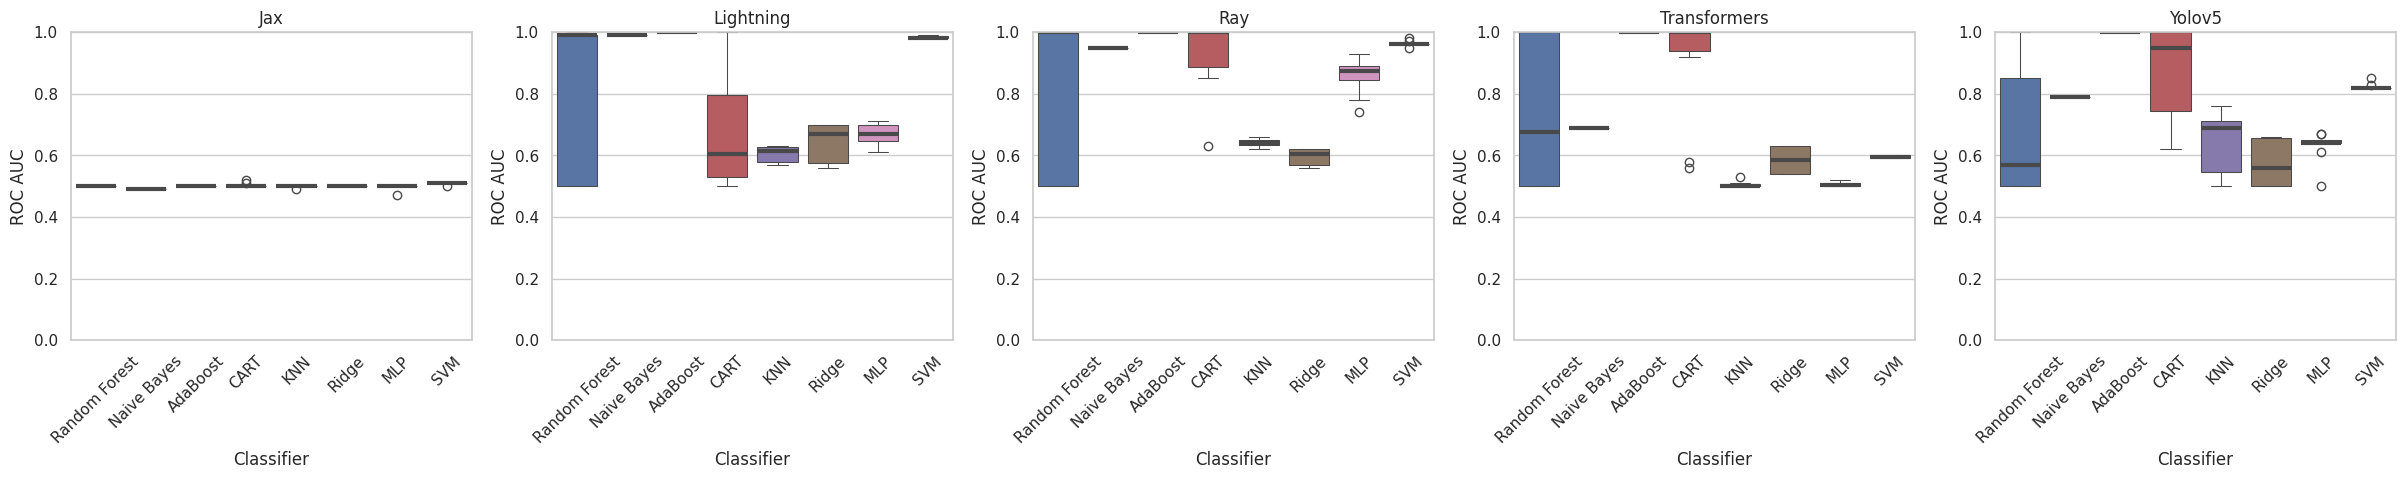

In [89]:
box_plots(data_jax, data_lightning, data_ray, data_transformers, data_yolov5)

In [38]:
grouped_stats = data_jax.groupby('Classifier')['ROC AUC'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_lightning.groupby('Classifier')['ROC AUC'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_ray.groupby('Classifier')['ROC AUC'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_transformers.groupby('Classifier')['ROC AUC'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_yolov5.groupby('Classifier')['ROC AUC'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')

                mean  median       std
Classifier                            
AdaBoost       0.500    0.50  0.000000
CART           0.503    0.50  0.006749
KNN            0.499    0.50  0.003162
MLP            0.497    0.50  0.009487
Naive Bayes    0.490    0.49  0.000000
Random Forest  0.500    0.50  0.000000
Ridge          0.500    0.50  0.000000
SVM            0.509    0.51  0.003162
-------------------------------------
                mean  median       std
Classifier                            
AdaBoost       1.000   1.000  0.000000
CART           0.672   0.605  0.197248
KNN            0.605   0.615  0.025927
MLP            0.669   0.670  0.032128
Naive Bayes    0.990   0.990  0.000000
Random Forest  0.796   0.990  0.254785
Ridge          0.642   0.670  0.063561
SVM            0.983   0.980  0.004830
-------------------------------------
                mean  median       std
Classifier                            
AdaBoost       1.000   1.000  0.000000
CART           0.933   1.00

# Main Code Running - Precision

In [39]:
print("Jax parameters hyper optimization (Precision: ")
# for jax
X_source, Y_source, X_target, Y_target = data_loading_jax()

all_precision_values_rf, all_precision_values_nb, all_precision_values_ada, all_precision_values_cart, all_precision_values_knn, all_precision_values_ridge, all_precision_values_mlp, all_precision_values_svm = hyperopt_classifier_pre()
#all_auc_values_svm = SVM_hyperopt_jax()
data_jax_pre = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_precision_values_rf) +
                    ['Naive Bayes'] * len(all_precision_values_nb) +
                    ['AdaBoost'] * len(all_precision_values_ada) +
                    ['CART'] * len(all_precision_values_cart) +
                    ['KNN'] * len(all_precision_values_knn) +
                    ['Ridge'] * len(all_precision_values_ridge) +
                    ['MLP'] * len(all_precision_values_mlp) +
                    ['SVM'] * len(all_precision_values_svm),
      'Precision': all_precision_values_rf + all_precision_values_nb + all_precision_values_ada + all_precision_values_cart + all_precision_values_knn + all_precision_values_ridge + all_precision_values_mlp + all_precision_values_svm
  })

data_jax_pre['Precision'] = pd.to_numeric(data_jax_pre['Precision'])
#print(data_jax_pre)

print("*****************************************************")

print("Lightning parameters hyper optimization: ")
# for Lightning
X_source, Y_source, X_target, Y_target = data_loading_lightning()
all_precision_values_rf, all_precision_values_nb, all_precision_values_ada, all_precision_values_cart, all_precision_values_knn, all_precision_values_ridge, all_precision_values_mlp, all_precision_values_svm = hyperopt_classifier_pre()
#all_auc_values_svm = SVM_hyperopt_lightning()
data_lightning_pre = pd.DataFrame({
       'Classifier': ['Random Forest'] * len(all_precision_values_rf) +
                    ['Naive Bayes'] * len(all_precision_values_nb) +
                    ['AdaBoost'] * len(all_precision_values_ada) +
                    ['CART'] * len(all_precision_values_cart) +
                    ['KNN'] * len(all_precision_values_knn) +
                    ['Ridge'] * len(all_precision_values_ridge) +
                    ['MLP'] * len(all_precision_values_mlp) +
                    ['SVM'] * len(all_precision_values_svm),
      'Precision': all_precision_values_rf + all_precision_values_nb + all_precision_values_ada + all_precision_values_cart + all_precision_values_knn + all_precision_values_ridge + all_precision_values_mlp + all_precision_values_svm
  })

data_lightning_pre['Precision'] = pd.to_numeric(data_lightning_pre['Precision'])

print("****************************************************")

print("Ray parameters hyper optimization: ")
# for Ray
X_source, Y_source, X_target, Y_target = data_loading_ray()
all_precision_values_rf, all_precision_values_nb, all_precision_values_ada, all_precision_values_cart, all_precision_values_knn, all_precision_values_ridge, all_precision_values_mlp, all_precision_values_svm = hyperopt_classifier_pre()
#all_auc_values_svm = SVM_hyperopt_ray()
data_ray_pre = pd.DataFrame({
       'Classifier': ['Random Forest'] * len(all_precision_values_rf) +
                    ['Naive Bayes'] * len(all_precision_values_nb) +
                    ['AdaBoost'] * len(all_precision_values_ada) +
                    ['CART'] * len(all_precision_values_cart) +
                    ['KNN'] * len(all_precision_values_knn) +
                    ['Ridge'] * len(all_precision_values_ridge) +
                    ['MLP'] * len(all_precision_values_mlp) +
                    ['SVM'] * len(all_precision_values_svm),
      'Precision': all_precision_values_rf + all_precision_values_nb + all_precision_values_ada + all_precision_values_cart + all_precision_values_knn + all_precision_values_ridge + all_precision_values_mlp + all_precision_values_svm
  })

data_ray_pre['Precision'] = pd.to_numeric(data_ray_pre['Precision'])

print("***********************************************************")

print("Transformers parameters hyper optimization: ")
X_source, Y_source, X_target, Y_target = data_loading_transformers()
all_precision_values_rf, all_precision_values_nb, all_precision_values_ada, all_precision_values_cart, all_precision_values_knn, all_precision_values_ridge, all_precision_values_mlp, all_precision_values_svm = hyperopt_classifier_pre()
#all_auc_values_svm = SVM_hyperopt_transformers()
data_transformers_pre = pd.DataFrame({
       'Classifier': ['Random Forest'] * len(all_precision_values_rf) +
                    ['Naive Bayes'] * len(all_precision_values_nb) +
                    ['AdaBoost'] * len(all_precision_values_ada) +
                    ['CART'] * len(all_precision_values_cart) +
                    ['KNN'] * len(all_precision_values_knn) +
                    ['Ridge'] * len(all_precision_values_ridge) +
                    ['MLP'] * len(all_precision_values_mlp) +
                    ['SVM'] * len(all_precision_values_svm),
      'Precision': all_precision_values_rf + all_precision_values_nb + all_precision_values_ada + all_precision_values_cart + all_precision_values_knn + all_precision_values_ridge + all_precision_values_mlp + all_precision_values_svm
  })
data_transformers_pre['Precision'] = pd.to_numeric(data_transformers_pre['Precision'])

print("*************************************************************")

print("Yolov5 parameters hyper optimization: ")
# for yolov5
X_source, Y_source, X_target, Y_target = data_loading_yolov5()
all_precision_values_rf, all_precision_values_nb, all_precision_values_ada, all_precision_values_cart, all_precision_values_knn, all_precision_values_ridge, all_precision_values_mlp, all_precision_values_svm = hyperopt_classifier_pre()
#all_auc_values_svm = SVM_hyperopt_yolov5()
data_yolov5_pre = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_precision_values_rf) +
                    ['Naive Bayes'] * len(all_precision_values_nb) +
                    ['AdaBoost'] * len(all_precision_values_ada) +
                    ['CART'] * len(all_precision_values_cart) +
                    ['KNN'] * len(all_precision_values_knn) +
                    ['Ridge'] * len(all_precision_values_ridge) +
                    ['MLP'] * len(all_precision_values_mlp) +
                    ['SVM'] * len(all_precision_values_svm),
      'Precision': all_precision_values_rf + all_precision_values_nb + all_precision_values_ada + all_precision_values_cart + all_precision_values_knn + all_precision_values_ridge + all_precision_values_mlp + all_precision_values_svm
  })

data_yolov5_pre['Precision'] = pd.to_numeric(data_yolov5_pre['Precision'])



Jax parameters hyper optimization (Precision: 
100%|███████████████████████| 10/10 [00:00<00:00, 31.89trial/s, best loss: -0.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 0.3329793384820623, 'n_estimators': 14}
100%|████████████████████| 10/10 [00:00<00:00, 221.56trial/s, best loss: -0.125]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 145.26trial/s, best loss: -0.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.844072997536529, 'n_estimators': 29}
100%|██████████████████████| 10/10 [00:00<00:00, 179.05trial/s, best loss: -0.5]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 7, 'splitter': 'random'}
100%|███████████████████████| 10/10 [00:00<00:00, 52.18trial/s, best loss: -0.0]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 16}
100%|███████████████████████| 10/10 [00:01<00:00,  7.13trial/s, best loss: -0.0]
Ridge: 

In [92]:
def box_plots_precision(data_jax, data_lightning, data_ray, data_transformers, data_yolov5):
  
    classifier_order = data_lightning['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))
    sns.set(style='whitegrid')

    # Plot box plots
    sns.boxplot(x='Classifier', y='Precision', data=data_jax, ax=axes[0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0].set_title('Jax')
    axes[0].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='Precision', data=data_lightning, ax=axes[1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1].set_title('Lightning')
    axes[1].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='Precision', data=data_ray, ax=axes[2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2].set_title('Ray')
    axes[2].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='Precision', data=data_transformers, ax=axes[3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3].set_title('Transformers')
    axes[3].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='Precision', data=data_yolov5, ax=axes[4], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[4].set_title('Yolov5')
    axes[4].set_ylim(0, 1)

    # Tilt x-axis labels
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        
    plt.savefig('wpdp_results_boxplots_precision.png', bbox_inches='tight')
    plt.show()




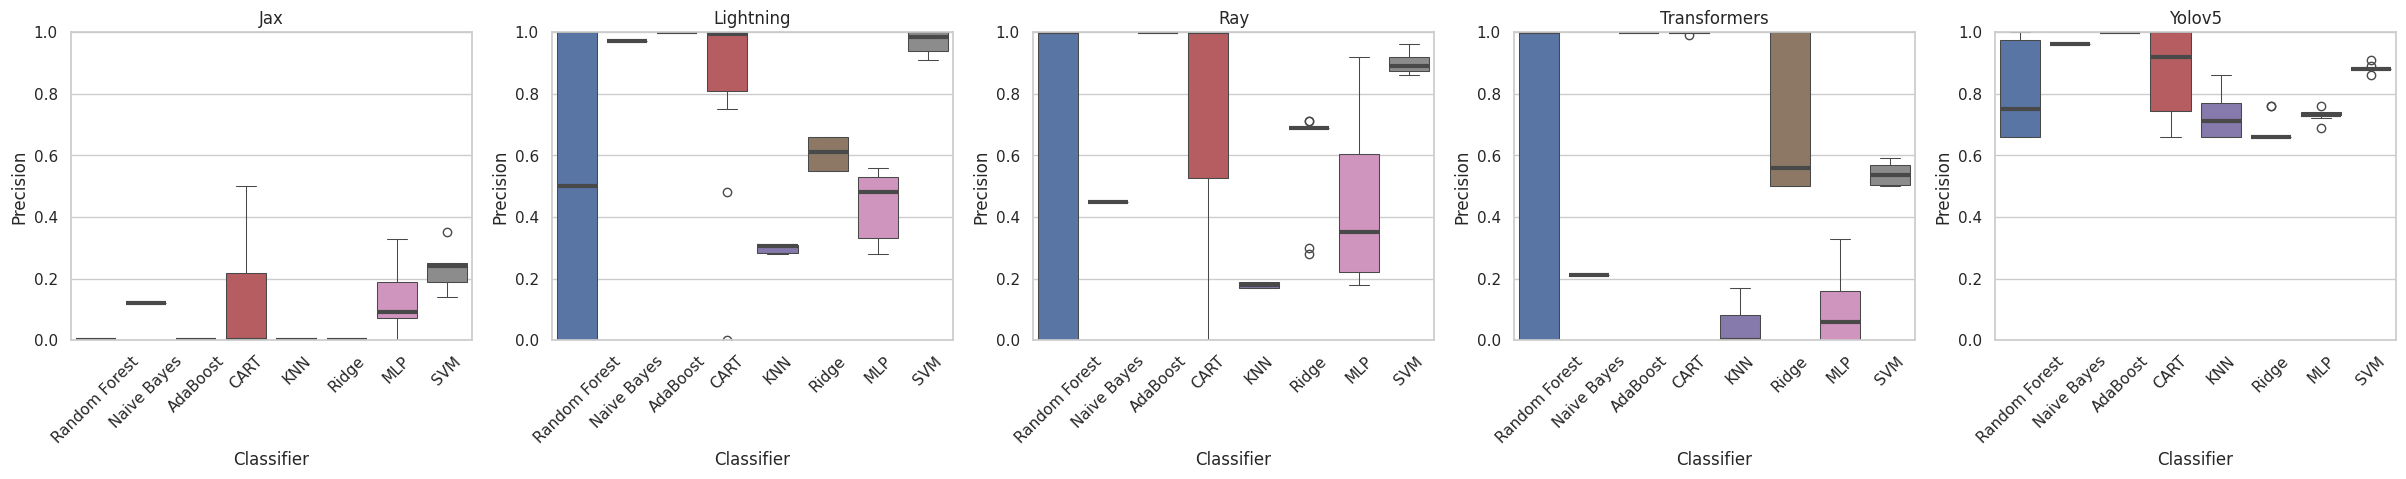

In [94]:
box_plots_precision(data_jax_pre, data_lightning_pre, data_ray_pre, data_transformers_pre, data_yolov5_pre)

In [49]:
grouped_stats = data_jax_pre.groupby('Classifier')['Precision'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_lightning_pre.groupby('Classifier')['Precision'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_ray_pre.groupby('Classifier')['Precision'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_transformers_pre.groupby('Classifier')['Precision'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_yolov5_pre.groupby('Classifier')['Precision'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')

                mean  median       std
Classifier                            
AdaBoost       0.000    0.00  0.000000
CART           0.120    0.00  0.180062
KNN            0.000    0.00  0.000000
MLP            0.126    0.09  0.106792
Naive Bayes    0.120    0.12  0.000000
Random Forest  0.000    0.00  0.000000
Ridge          0.000    0.00  0.000000
SVM            0.224    0.24  0.062397
-------------------------------------
                mean  median       std
Classifier                            
AdaBoost       1.000   1.000  0.000000
CART           0.820   0.995  0.334896
KNN            0.298   0.305  0.013984
MLP            0.441   0.480  0.113377
Naive Bayes    0.970   0.970  0.000000
Random Forest  0.500   0.500  0.527046
Ridge          0.606   0.610  0.056999
SVM            0.970   0.985  0.034641
-------------------------------------
                mean  median       std
Classifier                            
AdaBoost       1.000    1.00  0.000000
CART           0.763    1.0

# Main Running Code - Recall

In [42]:
print("Jax parameters hyper optimization (Recall: ")
# for jax
X_source, Y_source, X_target, Y_target = data_loading_jax()

all_recall_values_rf, all_recall_values_nb, all_recall_values_ada, all_recall_values_cart, all_recall_values_knn, all_recall_values_ridge, all_recall_values_mlp, all_recall_values_svm = hyperopt_classifier_re()
#all_auc_values_svm = SVM_hyperopt_jax()
data_jax_re = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_recall_values_rf) +
                    ['Naive Bayes'] * len(all_recall_values_nb) +
                    ['AdaBoost'] * len(all_recall_values_ada) +
                    ['CART'] * len(all_recall_values_cart) +
                    ['KNN'] * len(all_recall_values_knn) +
                    ['Ridge'] * len(all_recall_values_ridge) +
                    ['MLP'] * len(all_recall_values_mlp) +
                    ['SVM'] * len(all_recall_values_svm),
      'Recall': all_recall_values_rf + all_recall_values_nb + all_recall_values_ada + all_recall_values_cart + all_recall_values_knn + all_recall_values_ridge + all_recall_values_mlp + all_recall_values_svm
  })

data_jax_re['Recall'] = pd.to_numeric(data_jax_re['Recall'])
#print(data_jax_re)

print("*****************************************************")

print("Lightning parameters hyper optimization: ")
# for Lightning
X_source, Y_source, X_target, Y_target = data_loading_lightning()
all_recall_values_rf, all_recall_values_nb, all_recall_values_ada, all_recall_values_cart, all_recall_values_knn, all_recall_values_ridge, all_recall_values_mlp, all_recall_values_svm = hyperopt_classifier_re()
#all_auc_values_svm = SVM_hyperopt_lightning()
data_lightning_re = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_recall_values_rf) +
                    ['Naive Bayes'] * len(all_recall_values_nb) +
                    ['AdaBoost'] * len(all_recall_values_ada) +
                    ['CART'] * len(all_recall_values_cart) +
                    ['KNN'] * len(all_recall_values_knn) +
                    ['Ridge'] * len(all_recall_values_ridge) +
                    ['MLP'] * len(all_recall_values_mlp) +
                    ['SVM'] * len(all_recall_values_svm),
      'Recall': all_recall_values_rf + all_recall_values_nb + all_recall_values_ada + all_recall_values_cart + all_recall_values_knn + all_recall_values_ridge + all_recall_values_mlp + all_recall_values_svm
  })

data_lightning_re['Recall'] = pd.to_numeric(data_lightning_re['Recall'])

print("****************************************************")

print("Ray parameters hyper optimization: ")
# for Ray
X_source, Y_source, X_target, Y_target = data_loading_ray()
all_recall_values_rf, all_recall_values_nb, all_recall_values_ada, all_recall_values_cart, all_recall_values_knn, all_recall_values_ridge, all_recall_values_mlp, all_recall_values_svm = hyperopt_classifier_re()
#all_auc_values_svm = SVM_hyperopt_ray()
data_ray_re = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_recall_values_rf) +
                    ['Naive Bayes'] * len(all_recall_values_nb) +
                    ['AdaBoost'] * len(all_recall_values_ada) +
                    ['CART'] * len(all_recall_values_cart) +
                    ['KNN'] * len(all_recall_values_knn) +
                    ['Ridge'] * len(all_recall_values_ridge) +
                    ['MLP'] * len(all_recall_values_mlp) +
                    ['SVM'] * len(all_recall_values_svm),
      'Recall': all_recall_values_rf + all_recall_values_nb + all_recall_values_ada + all_recall_values_cart + all_recall_values_knn + all_recall_values_ridge + all_recall_values_mlp + all_recall_values_svm
  })

data_ray_re['Recall'] = pd.to_numeric(data_ray_re['Recall'])

print("***********************************************************")

print("Transformers parameters hyper optimization: ")
X_source, Y_source, X_target, Y_target = data_loading_transformers()
all_recall_values_rf, all_recall_values_nb, all_recall_values_ada, all_recall_values_cart, all_recall_values_knn, all_recall_values_ridge, all_recall_values_mlp, all_recall_values_svm = hyperopt_classifier_re()
#all_auc_values_svm = SVM_hyperopt_transformers()
data_transformers_re = pd.DataFrame({
       'Classifier': ['Random Forest'] * len(all_recall_values_rf) +
                    ['Naive Bayes'] * len(all_recall_values_nb) +
                    ['AdaBoost'] * len(all_recall_values_ada) +
                    ['CART'] * len(all_recall_values_cart) +
                    ['KNN'] * len(all_recall_values_knn) +
                    ['Ridge'] * len(all_recall_values_ridge) +
                    ['MLP'] * len(all_recall_values_mlp) +
                    ['SVM'] * len(all_recall_values_svm),
      'Recall': all_recall_values_rf + all_recall_values_nb + all_recall_values_ada + all_recall_values_cart + all_recall_values_knn + all_recall_values_ridge + all_recall_values_mlp + all_recall_values_svm
  })
data_transformers_re['Recall'] = pd.to_numeric(data_transformers_re['Recall'])

print("*************************************************************")

print("Yolov5 parameters hyper optimization: ")
# for yolov5
X_source, Y_source, X_target, Y_target = data_loading_yolov5()
all_recall_values_rf, all_recall_values_nb, all_recall_values_ada, all_recall_values_cart, all_recall_values_knn, all_recall_values_ridge, all_recall_values_mlp, all_recall_values_svm = hyperopt_classifier_re()
#all_auc_values_svm = SVM_hyperopt_yolov5()
data_yolov5_re = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_recall_values_rf) +
                    ['Naive Bayes'] * len(all_recall_values_nb) +
                    ['AdaBoost'] * len(all_recall_values_ada) +
                    ['CART'] * len(all_recall_values_cart) +
                    ['KNN'] * len(all_recall_values_knn) +
                    ['Ridge'] * len(all_recall_values_ridge) +
                    ['MLP'] * len(all_recall_values_mlp) +
                    ['SVM'] * len(all_recall_values_svm),
      'Recall': all_recall_values_rf + all_recall_values_nb + all_recall_values_ada + all_recall_values_cart + all_recall_values_knn + all_recall_values_ridge + all_recall_values_mlp + all_recall_values_svm
  })

data_yolov5_re['Recall'] = pd.to_numeric(data_yolov5_re['Recall'])



Jax parameters hyper optimization (Recall: 
100%|███████████████████████| 10/10 [00:00<00:00, 22.69trial/s, best loss: -0.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 0.2941314872303552, 'n_estimators': 27}
100%|██████| 10/10 [00:00<00:00, 229.89trial/s, best loss: -0.06060606060606061]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 149.13trial/s, best loss: -0.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.57482752742488, 'n_estimators': 48}
100%|██████| 10/10 [00:00<00:00, 182.11trial/s, best loss: -0.06060606060606061]
CART:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 7, 'splitter': 'random'}
100%|███████████████████████| 10/10 [00:00<00:00, 60.81trial/s, best loss: -0.0]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 13}
100%|███████████████████████| 10/10 [00:01<00:00,  5.11trial/s, best loss: -0.0]
Ridge:  

In [90]:
def box_plots_recall(data_jax, data_lightning, data_ray, data_transformers, data_yolov5):
  
    classifier_order = data_lightning['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))
    sns.set(style='whitegrid')

    # Plot box plots
    sns.boxplot(x='Classifier', y='Recall', data=data_jax, ax=axes[0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0].set_title('Jax')
    axes[0].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='Recall', data=data_lightning, ax=axes[1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1].set_title('Lightning')
    axes[1].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='Recall', data=data_ray, ax=axes[2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2].set_title('Ray')
    axes[2].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='Recall', data=data_transformers, ax=axes[3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3].set_title('Transformers')
    axes[3].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='Recall', data=data_yolov5, ax=axes[4], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[4].set_title('Yolov5')
    axes[4].set_ylim(0, 1)

    # Tilt x-axis labels
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        
    plt.savefig('wpdp_results_boxplots_recall.png', bbox_inches='tight')
    plt.show()




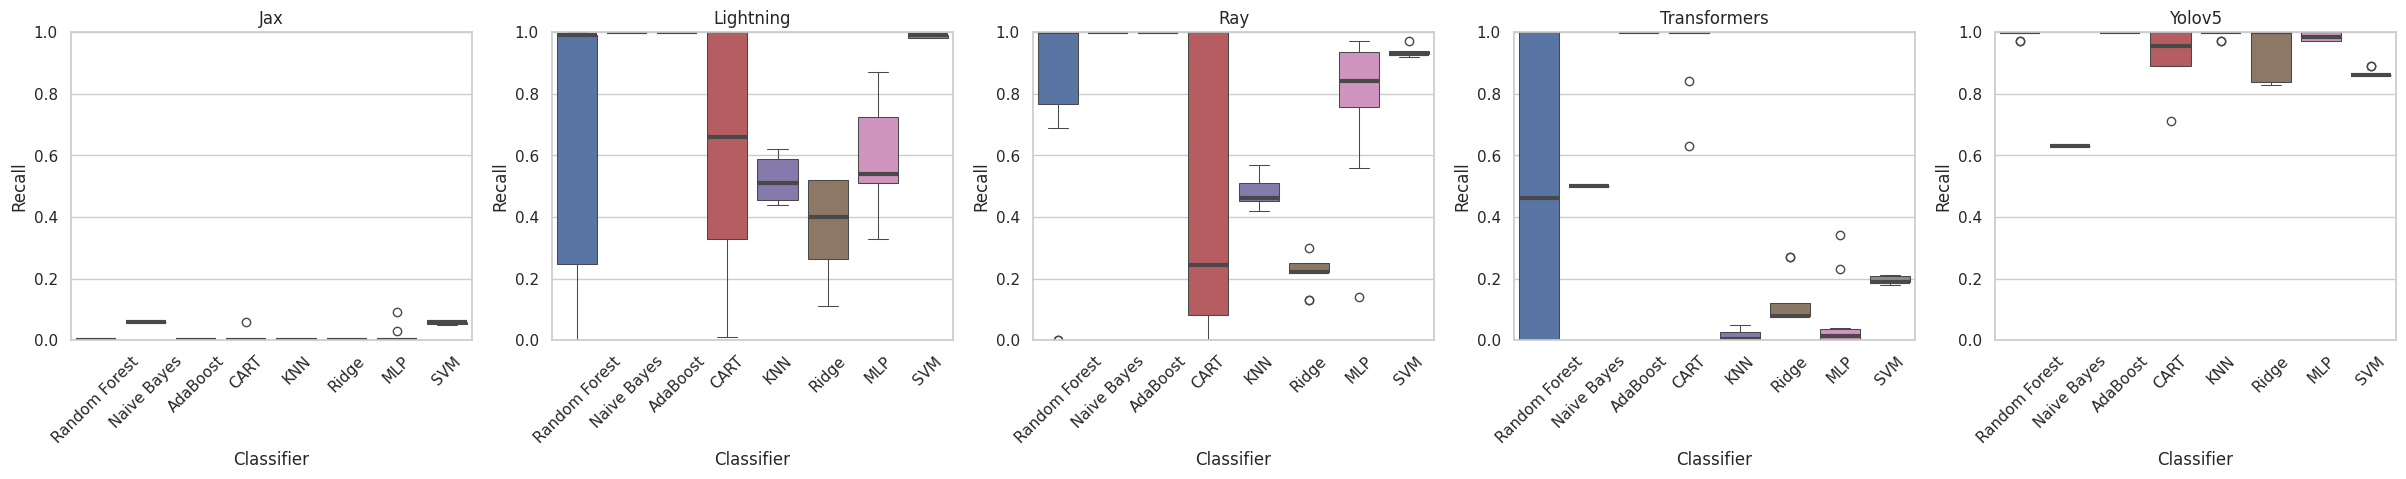

In [91]:
box_plots_recall(data_jax_re, data_lightning_re, data_ray_re, data_transformers_re, data_yolov5_re)

In [50]:
grouped_stats = data_jax_re.groupby('Classifier')['Recall'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_lightning_re.groupby('Classifier')['Recall'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_ray_re.groupby('Classifier')['Recall'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_transformers_re.groupby('Classifier')['Recall'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_yolov5_re.groupby('Classifier')['Recall'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')

                mean  median       std
Classifier                            
AdaBoost       0.000    0.00  0.000000
CART           0.006    0.00  0.018974
KNN            0.000    0.00  0.000000
MLP            0.012    0.00  0.028983
Naive Bayes    0.060    0.06  0.000000
Random Forest  0.000    0.00  0.000000
Ridge          0.000    0.00  0.000000
SVM            0.057    0.06  0.004830
-------------------------------------
                mean  median       std
Classifier                            
AdaBoost       1.000    1.00  0.000000
CART           0.635    0.66  0.379715
KNN            0.521    0.51  0.072946
MLP            0.606    0.54  0.176081
Naive Bayes    1.000    1.00  0.000000
Random Forest  0.695    0.99  0.479612
Ridge          0.377    0.40  0.158609
SVM            0.986    0.99  0.005164
-------------------------------------
                mean  median       std
Classifier                            
AdaBoost       1.000   1.000  0.000000
CART           0.476   0.24

# Main Running Code - F1

In [62]:
print("Jax parameters hyper optimization (F1): ")
# for jax
X_source, Y_source, X_target, Y_target = data_loading_jax()

all_f1_values_rf, all_f1_values_nb, all_f1_values_ada, all_f1_values_cart, all_f1_values_knn, all_f1_values_ridge, all_f1_values_mlp, all_f1_values_svm = hyperopt_classifier_f1()
#all_auc_values_svm = SVM_hyperopt_jax()
data_jax_f1 = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_f1_values_rf) +
                    ['Naive Bayes'] * len(all_f1_values_nb) +
                    ['AdaBoost'] * len(all_f1_values_ada) +
                    ['CART'] * len(all_f1_values_cart) +
                    ['KNN'] * len(all_f1_values_knn) +
                    ['Ridge'] * len(all_f1_values_ridge) +
                    ['MLP'] * len(all_f1_values_mlp) +
                    ['SVM'] * len(all_f1_values_svm),
      'F1': all_f1_values_rf + all_f1_values_nb + all_f1_values_ada + all_f1_values_cart + all_f1_values_knn + all_f1_values_ridge + all_f1_values_mlp + all_f1_values_svm
  })

data_jax_f1['F1'] = pd.to_numeric(data_jax_f1['F1'])
#print(data_jax_f1)

print("*****************************************************")

print("Lightning parameters hyper optimization: ")
# for Lightning
X_source, Y_source, X_target, Y_target = data_loading_lightning()
all_f1_values_rf, all_f1_values_nb, all_f1_values_ada, all_f1_values_cart, all_f1_values_knn, all_f1_values_ridge, all_f1_values_mlp, all_f1_values_svm = hyperopt_classifier_f1()
#all_auc_values_svm = SVM_hyperopt_lightning()
data_lightning_f1 = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_f1_values_rf) +
                    ['Naive Bayes'] * len(all_f1_values_nb) +
                    ['AdaBoost'] * len(all_f1_values_ada) +
                    ['CART'] * len(all_f1_values_cart) +
                    ['KNN'] * len(all_f1_values_knn) +
                    ['Ridge'] * len(all_f1_values_ridge) +
                    ['MLP'] * len(all_f1_values_mlp) +
                    ['SVM'] * len(all_f1_values_svm),
      'F1': all_f1_values_rf + all_f1_values_nb + all_f1_values_ada + all_f1_values_cart + all_f1_values_knn + all_f1_values_ridge + all_f1_values_mlp + all_f1_values_svm
  })

data_lightning_f1['F1'] = pd.to_numeric(data_lightning_f1['F1'])

print("****************************************************")

print("Ray parameters hyper optimization: ")
# for Ray
X_source, Y_source, X_target, Y_target = data_loading_ray()
all_f1_values_rf, all_f1_values_nb, all_f1_values_ada, all_f1_values_cart, all_f1_values_knn, all_f1_values_ridge, all_f1_values_mlp, all_f1_values_svm = hyperopt_classifier_f1()
#all_auc_values_svm = SVM_hyperopt_ray()
data_ray_f1 = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_f1_values_rf) +
                    ['Naive Bayes'] * len(all_f1_values_nb) +
                    ['AdaBoost'] * len(all_f1_values_ada) +
                    ['CART'] * len(all_f1_values_cart) +
                    ['KNN'] * len(all_f1_values_knn) +
                    ['Ridge'] * len(all_f1_values_ridge) +
                    ['MLP'] * len(all_f1_values_mlp) +
                    ['SVM'] * len(all_f1_values_svm),
      'F1': all_f1_values_rf + all_f1_values_nb + all_f1_values_ada + all_f1_values_cart + all_f1_values_knn + all_f1_values_ridge + all_f1_values_mlp + all_f1_values_svm
  })

data_ray_f1['F1'] = pd.to_numeric(data_ray_f1['F1'])

print("***********************************************************")

print("Transformers parameters hyper optimization: ")
X_source, Y_source, X_target, Y_target = data_loading_transformers()
all_f1_values_rf, all_f1_values_nb, all_f1_values_ada, all_f1_values_cart, all_f1_values_knn, all_f1_values_ridge, all_f1_values_mlp, all_f1_values_svm = hyperopt_classifier_f1()
#all_auc_values_svm = SVM_hyperopt_transformers()
data_transformers_f1 = pd.DataFrame({
       'Classifier': ['Random Forest'] * len(all_f1_values_rf) +
                    ['Naive Bayes'] * len(all_f1_values_nb) +
                    ['AdaBoost'] * len(all_f1_values_ada) +
                    ['CART'] * len(all_f1_values_cart) +
                    ['KNN'] * len(all_f1_values_knn) +
                    ['Ridge'] * len(all_f1_values_ridge) +
                    ['MLP'] * len(all_f1_values_mlp) +
                    ['SVM'] * len(all_f1_values_svm),
      'F1': all_f1_values_rf + all_f1_values_nb + all_f1_values_ada + all_f1_values_cart + all_f1_values_knn + all_f1_values_ridge + all_f1_values_mlp + all_f1_values_svm
  })
data_transformers_f1['F1'] = pd.to_numeric(data_transformers_f1['F1'])

print("*************************************************************")

print("Yolov5 parameters hyper optimization: ")
# for yolov5
X_source, Y_source, X_target, Y_target = data_loading_yolov5()
all_f1_values_rf, all_f1_values_nb, all_f1_values_ada, all_f1_values_cart, all_f1_values_knn, all_f1_values_ridge, all_f1_values_mlp, all_f1_values_svm = hyperopt_classifier_f1()
#all_auc_values_svm = SVM_hyperopt_yolov5()
data_yolov5_f1 = pd.DataFrame({
      'Classifier': ['Random Forest'] * len(all_f1_values_rf) +
                    ['Naive Bayes'] * len(all_f1_values_nb) +
                    ['AdaBoost'] * len(all_f1_values_ada) +
                    ['CART'] * len(all_f1_values_cart) +
                    ['KNN'] * len(all_f1_values_knn) +
                    ['Ridge'] * len(all_f1_values_ridge) +
                    ['MLP'] * len(all_f1_values_mlp) +
                    ['SVM'] * len(all_f1_values_svm),
      'F1': all_f1_values_rf + all_f1_values_nb + all_f1_values_ada + all_f1_values_cart + all_f1_values_knn + all_f1_values_ridge + all_f1_values_mlp + all_f1_values_svm
  })

data_yolov5_f1['F1'] = pd.to_numeric(data_yolov5_f1['F1'])



Jax parameters hyper optimization (F1): 
100%|███████████████████████| 10/10 [00:00<00:00, 38.95trial/s, best loss: -0.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 0.45931853796211086, 'n_estimators': 25}
100%|███████| 10/10 [00:00<00:00, 216.30trial/s, best loss: -0.0816326530612245]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 143.78trial/s, best loss: -0.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.9650430032505362, 'n_estimators': 45}
100%|██████| 10/10 [00:00<00:00, 179.68trial/s, best loss: -0.08450704225352113]
CART:  {'criterion': 'log_loss', 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 8, 'splitter': 'random'}
100%|███████████████████████| 10/10 [00:00<00:00, 59.86trial/s, best loss: -0.0]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 12}
100%|███████████████████████| 10/10 [00:02<00:00,  3.63trial/s, best loss: -0.0]
Ridge:

In [83]:
def box_plots_f1(data_jax, data_lightning, data_ray, data_transformers, data_yolov5):
  
    classifier_order = data_lightning['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))
    sns.set(style='whitegrid')

    # Plot box plots
    sns.boxplot(x='Classifier', y='F1', data=data_jax, ax=axes[0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0].set_title('Jax')
    axes[0].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='F1', data=data_lightning, ax=axes[1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1].set_title('Lightning')
    axes[1].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='F1', data=data_ray, ax=axes[2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2].set_title('Ray')
    axes[2].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='F1', data=data_transformers, ax=axes[3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3].set_title('Transformers')
    axes[3].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='F1', data=data_yolov5, ax=axes[4], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[4].set_title('Yolov5')
    axes[4].set_ylim(0, 1)

    # Tilt x-axis labels
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        
    plt.savefig('wpdp_results_boxplots_f1.png', bbox_inches='tight')
    plt.show()




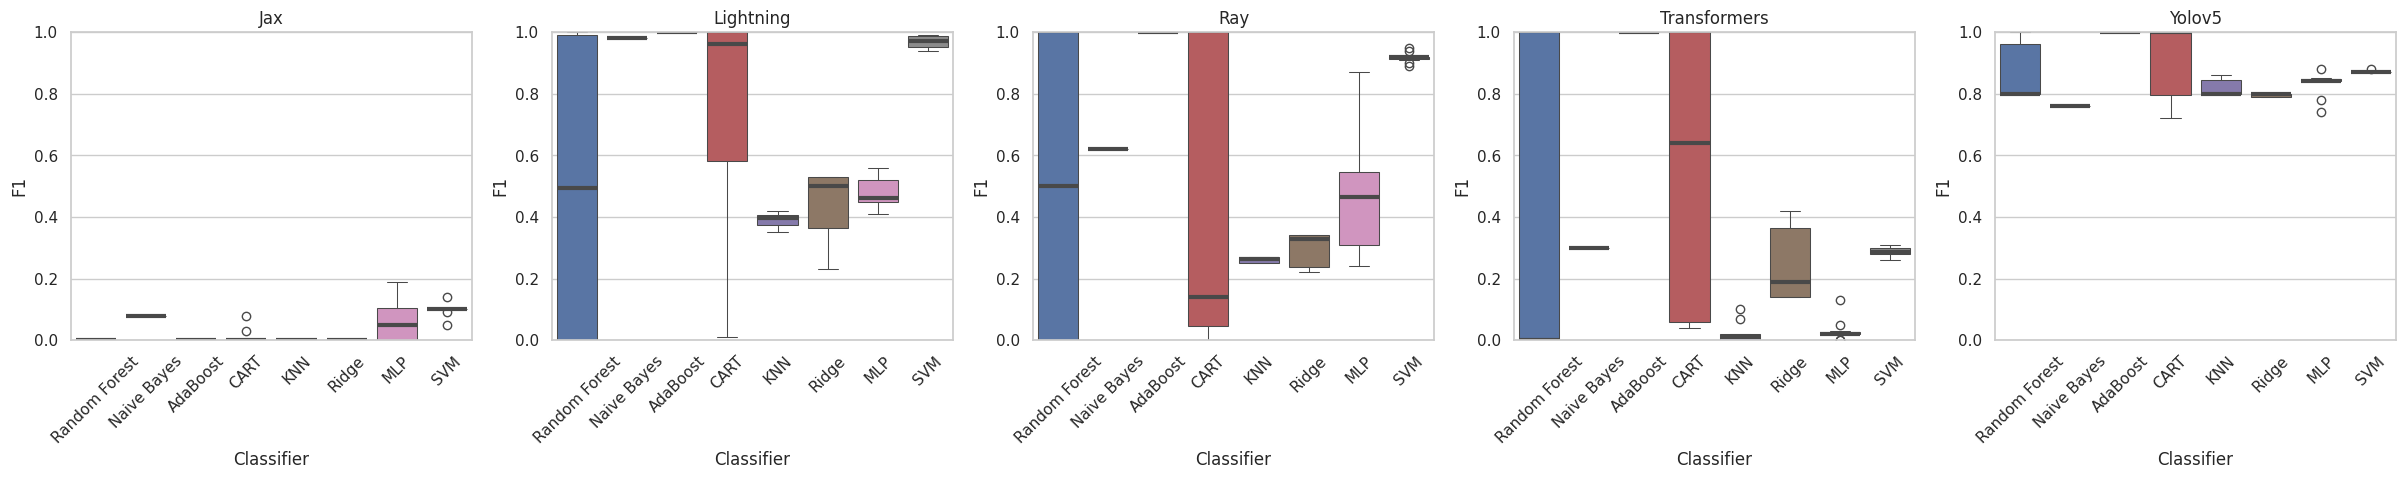

In [84]:
box_plots_f1(data_jax_f1, data_lightning_f1, data_ray_f1, data_transformers_f1, data_yolov5_f1)

In [66]:
grouped_stats = data_jax_f1.groupby('Classifier')['F1'].agg(['mean', 'median', 'std'])
print("Jax")
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_lightning_f1.groupby('Classifier')['F1'].agg(['mean', 'median', 'std'])
print("Lightning")
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_ray_f1.groupby('Classifier')['F1'].agg(['mean', 'median', 'std'])
print("Ray")
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_transformers_f1.groupby('Classifier')['F1'].agg(['mean', 'median', 'std'])
print("Transformers")
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_yolov5_f1.groupby('Classifier')['F1'].agg(['mean', 'median', 'std'])
print("Yolov5")
print(grouped_stats)
print('-------------------------------------')

Jax
                mean  median       std
Classifier                            
AdaBoost       0.000    0.00  0.000000
CART           0.011    0.00  0.026013
KNN            0.000    0.00  0.000000
MLP            0.068    0.05  0.075395
Naive Bayes    0.080    0.08  0.000000
Random Forest  0.000    0.00  0.000000
Ridge          0.000    0.00  0.000000
SVM            0.098    0.10  0.021499
-------------------------------------
Lightning
                mean  median       std
Classifier                            
AdaBoost       1.000   1.000  0.000000
CART           0.775   0.960  0.340074
KNN            0.390   0.395  0.024495
MLP            0.479   0.460  0.051737
Naive Bayes    0.980   0.980  0.000000
Random Forest  0.497   0.495  0.523897
Ridge          0.442   0.500  0.123720
SVM            0.969   0.970  0.019120
-------------------------------------
Ray
                mean  median       std
Classifier                            
AdaBoost       1.000   1.000  0.000000
CART     

In [77]:
def box_plots_all(data_jax, data_lightning, data_ray, data_transformers, data_yolov5,
                  data_jax_pre, data_lightning_pre, data_ray_pre, data_transformers_pre, data_yolov5_pre,
                  data_jax_re, data_lightning_re, data_ray_re, data_transformers_re, data_yolov5_re,
                  data_jax_f1, data_lightning_f1, data_ray_f1, data_transformers_f1, data_yolov5_f1):

    classifier_order = data_jax['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(60, 16))
    # sns.set(style='darkgrid')
    sns.set_style('whitegrid')
    # sns.color_palette("deep")
    # plt.rcParams['font.family'] = 'Times New Roman'
    # sns.set_context(fontfamily="Verdana")

    # Plot box plots for ROC AUC
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_jax, ax=axes[0, 0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0, 0].set_title('Jax', fontsize=20)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='ROC AUC', data=data_lightning, ax=axes[0, 1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0, 1].set_title('Lightning', fontsize=20)
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='ROC AUC', data=data_ray, ax=axes[0, 2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0, 2].set_title('Ray', fontsize=20)
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='ROC AUC', data=data_transformers, ax=axes[0, 3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0, 3].set_title('Transformers', fontsize=20)
    axes[0, 3].set_ylim(0, 1)
    axes[0, 3].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='ROC AUC', data=data_yolov5, ax=axes[0, 4], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0, 4].set_title('Yolov5', fontsize=20)
    axes[0, 4].set_ylim(0, 1)
    axes[0, 4].set_ylabel('ROC AUC', fontsize=15)

    # Plot box plots for Precision
    sns.boxplot(x='Classifier', y='Precision', data=data_jax_pre, ax=axes[1, 0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1, 0].set_title('Jax', fontsize=20)
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_lightning_pre, ax=axes[1, 1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1, 1].set_title('Lightning', fontsize=20)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_ray_pre, ax=axes[1, 2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1, 2].set_title('Ray', fontsize=20)
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_transformers_pre, ax=axes[1, 3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1, 3].set_title('Transformers', fontsize=20)
    axes[1, 3].set_ylim(0, 1)
    axes[1, 3].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_yolov5_pre, ax=axes[1, 4], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1, 4].set_title('Yolov5', fontsize=20)
    axes[1, 4].set_ylim(0, 1)
    axes[1, 4].set_ylabel('Precision', fontsize=15)

    # Plot box plots for Recall
    sns.boxplot(x='Classifier', y='Recall', data=data_jax_re, ax=axes[2, 0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2, 0].set_title('Jax', fontsize=20)
    axes[2, 0].set_ylim(0, 1)
    axes[2, 0].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_lightning_re, ax=axes[2, 1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2, 1].set_title('Lightning', fontsize=20)
    axes[2, 1].set_ylim(0, 1)
    axes[2, 1].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_ray_re, ax=axes[2, 2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2, 2].set_title('Ray', fontsize=20)
    axes[2, 2].set_ylim(0, 1)
    axes[2, 2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_transformers_re, ax=axes[2, 3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2, 3].set_title('Transformers', fontsize=20)
    axes[2, 3].set_ylim(0, 1)

    sns.boxplot(x='Classifier', y='Recall', data=data_yolov5_re, ax=axes[2, 4], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2, 4].set_title('Yolov5', fontsize=20)
    axes[2, 4].set_ylim(0, 1)
    axes[2, 4].set_ylabel('Recall', fontsize=15)

    # Plot box plots for F1
    sns.boxplot(x='Classifier', y='F1', data=data_jax_f1, ax=axes[3, 0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3, 0].set_title('Jax', fontsize=20)
    axes[3, 0].set_ylim(0, 1)
    axes[3, 0].set_ylabel('F1', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_lightning_f1, ax=axes[3, 1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3, 1].set_title('Lightning', fontsize=20)
    axes[3, 1].set_ylim(0, 1)
    axes[3, 1].set_ylabel('F1', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_ray_f1, ax=axes[3, 2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3, 2].set_title('Ray', fontsize=20)
    axes[3, 2].set_ylim(0, 1)
    axes[3, 2].set_ylabel('F1', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_transformers_f1, ax=axes[3, 3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3, 3].set_title('Transformers', fontsize=20)
    axes[3, 3].set_ylim(0, 1)
    axes[3, 3].set_ylabel('F1', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_yolov5_f1, ax=axes[3, 4], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3, 4].set_title('Yolov5', fontsize=20)
    axes[3, 4].set_ylim(0, 1)
    axes[3, 4].set_ylabel('F1', fontsize=15)

    plt.subplots_adjust(hspace=0.5)

    # Tilt x-axis labels
    for ax in axes.flatten():
        ax.tick_params(axis='x', rotation=45)
        
    plt.savefig('wpdp_results_boxplots_ALL.png', bbox_inches='tight')
    plt.show()


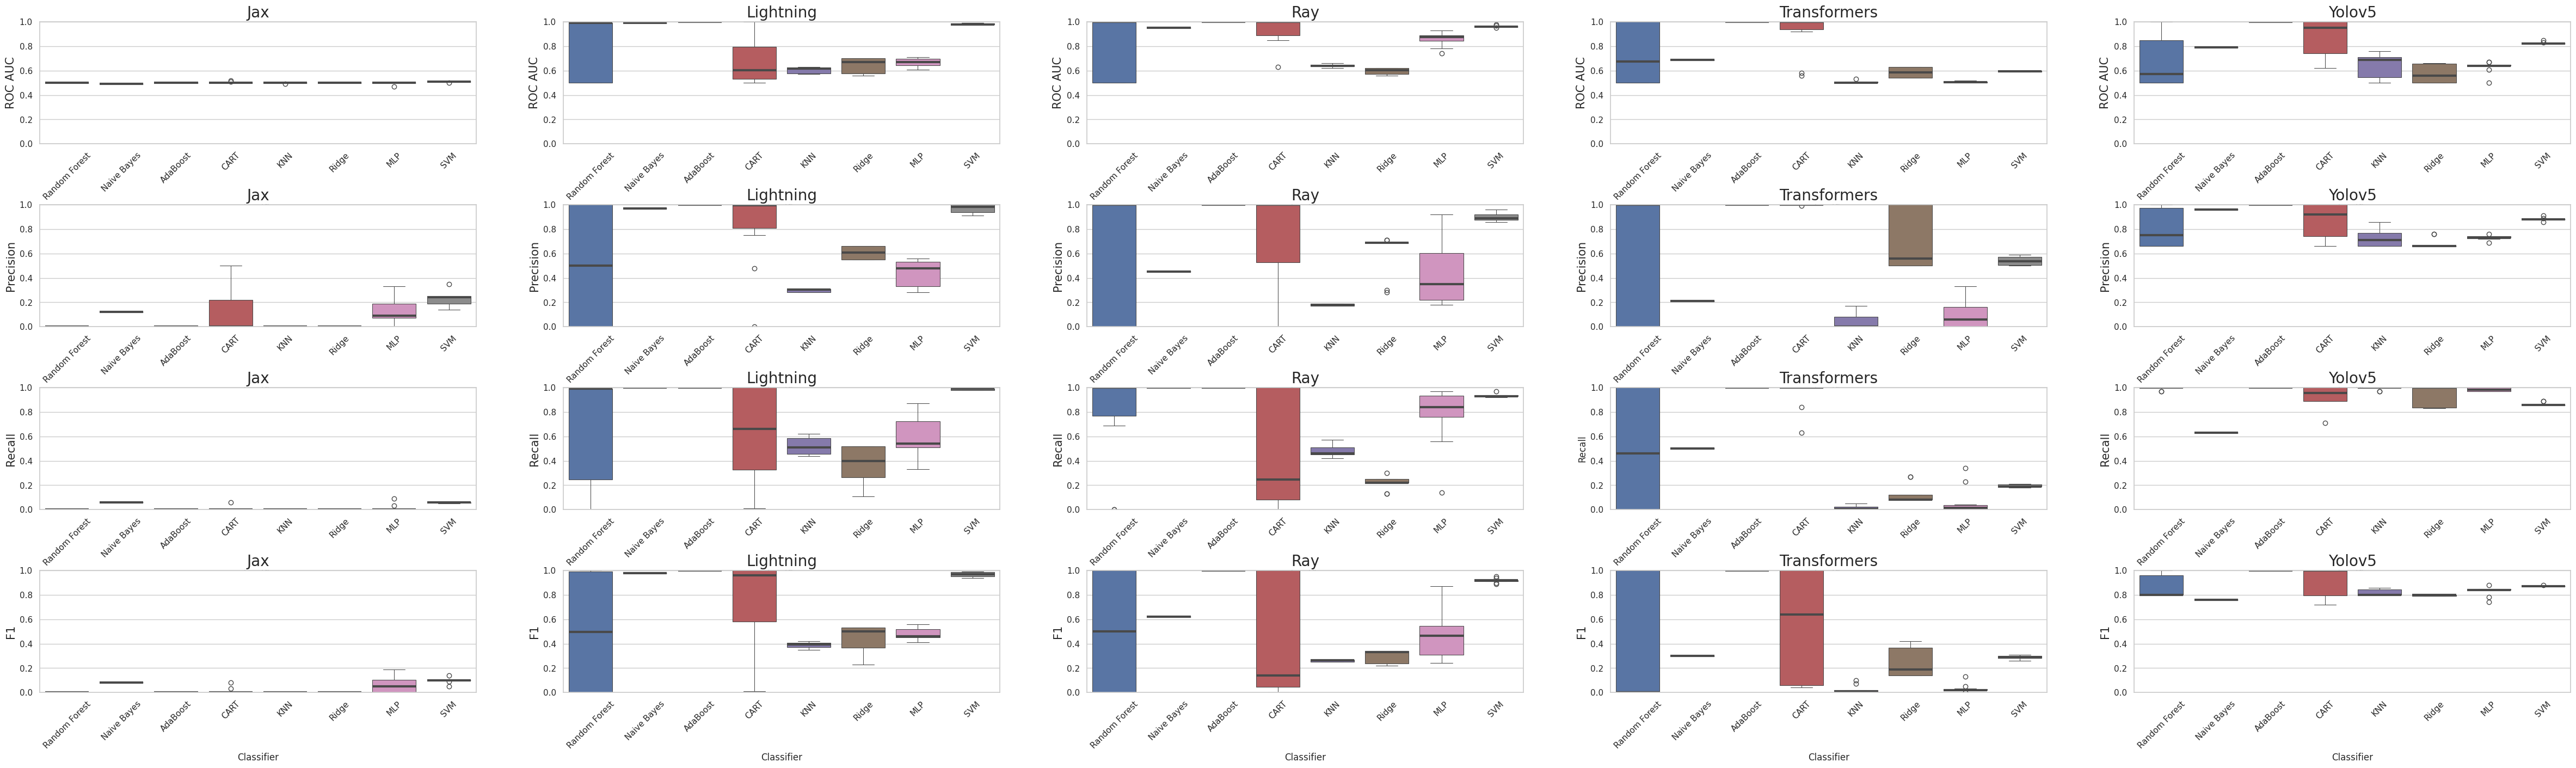

In [78]:
box_plots_all(data_jax, data_lightning, data_ray, data_transformers, data_yolov5, data_jax_pre, data_lightning_pre, data_ray_pre, data_transformers_pre, data_yolov5_pre, data_jax_re, data_lightning_re, data_ray_re, data_transformers_re, data_yolov5_re, data_jax_f1, data_lightning_f1, data_ray_f1, data_transformers_f1, data_yolov5_f1)



In [58]:
%store data_jax 
%store data_lightning
%store data_ray 
%store data_transformers 
%store data_yolov5 
%store data_jax_pre 
%store data_lightning_pre 
%store data_ray_pre 
%store data_transformers_pre 
%store data_yolov5_pre 
%store data_jax_re 
%store data_lightning_re 
%store data_ray_re 
%store data_transformers_re 
%store data_yolov5_re 
%store data_jax_f1  
%store data_lightning_f1
%store data_ray_f1
%store data_transformers_f1 
%store data_yolov5_f1

Stored 'data_jax' (DataFrame)
Stored 'data_lightning' (DataFrame)
Stored 'data_ray' (DataFrame)
Stored 'data_transformers' (DataFrame)
Stored 'data_yolov5' (DataFrame)
Stored 'data_jax_pre' (DataFrame)
Stored 'data_lightning_pre' (DataFrame)
Stored 'data_ray_pre' (DataFrame)
Stored 'data_transformers_pre' (DataFrame)
Stored 'data_yolov5_pre' (DataFrame)
Stored 'data_jax_re' (DataFrame)
Stored 'data_lightning_re' (DataFrame)
Stored 'data_ray_re' (DataFrame)
Stored 'data_transformers_re' (DataFrame)
Stored 'data_yolov5_re' (DataFrame)
Stored 'data_jax_f1' (DataFrame)
Stored 'data_lightning_f1' (DataFrame)
Stored 'data_ray_f1' (DataFrame)
Stored 'data_transformers_f1' (DataFrame)
Stored 'data_yolov5_f1' (DataFrame)


In [59]:
%store

Stored variables and their in-db values:
data_jax                          ->        Classifier  ROC AUC
0   Random Forest     0
data_jax_f1                       ->        Classifier    F1
0   Random Forest  0.00
1 
data_jax_pre                      ->        Classifier  Precision
0   Random Forest    
data_jax_re                       ->        Classifier  Recall
0   Random Forest    0.0
data_lightning                    ->        Classifier  ROC AUC
0   Random Forest     0
data_lightning_f1                 ->        Classifier    F1
0   Random Forest  0.99
1 
data_lightning_pre                ->        Classifier  Precision
0   Random Forest    
data_lightning_re                 ->        Classifier  Recall
0   Random Forest    0.9
data_ray                          ->        Classifier  ROC AUC
0   Random Forest     1
data_ray_f1                       ->        Classifier    F1
0   Random Forest  1.00
1 
data_ray_pre                      ->        Classifier  Precision
0   Random Fo